In [79]:
%matplotlib inline
from matplotlib import style
style.use('Solarize_Light2')
import matplotlib.pyplot as plt

In [80]:
from scipy import stats 
import numpy as np
import pandas as pd

In [81]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [82]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [83]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [84]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [85]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [86]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [87]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [88]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f915730b7b8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [89]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f915730b668>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

In [90]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
min_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d').date() - dt.timedelta(weeks=52)

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= min_date).\
order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year, columns=['Date', 'Precipitation'])
last_year_df.set_index('Date', inplace=True)
last_year_df.head(100)

,Precipitation
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
...,...
2017-07-31,0.00
2017-07-31,0.00
2017-07-31,0.00


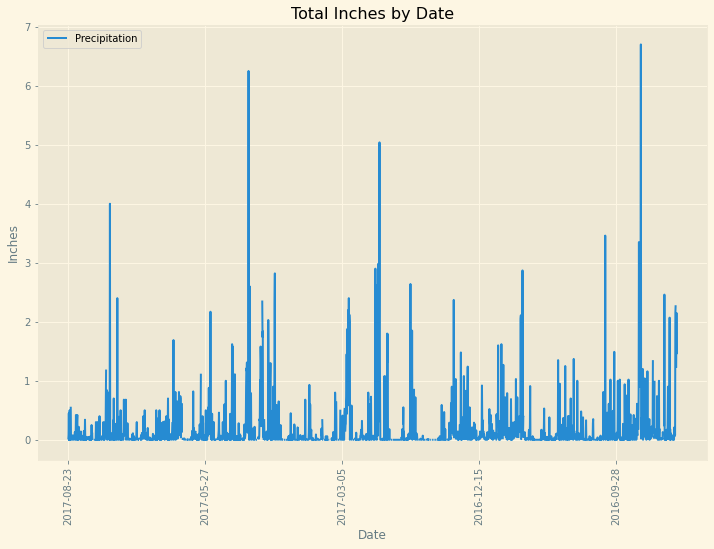

In [91]:
# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot.line(figsize=(12, 8))
plt.xticks(rotation="vertical")

plt.xlabel("Date")
plt.ylabel("Inches")
plt.title('Total Inches by Date')
plt.show()

In [92]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_df = last_year_df.agg({"Precipitation": ["mean", "median", "var", "std", "sem"]})
summary_df.head()

,Precipitation
mean,0.176462
median,0.020000
var,0.211865
std,0.460288
sem,0.010254


In [93]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
station_count

9

In [94]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
                                order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [95]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_info = session.query(Measurement.station, 
    func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()
station_info

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

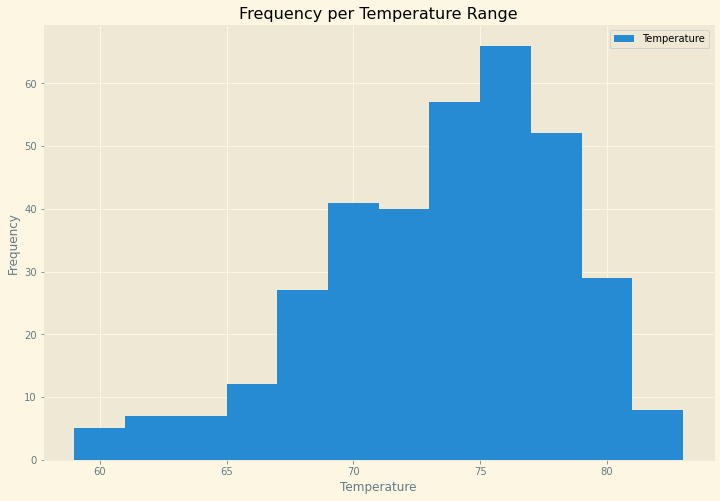

In [96]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_info = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").\
filter(Measurement.date >= min_date).all()

station_df = pd.DataFrame(station_info, columns=['Temperature'])
station_df.plot.hist(bins=12,figsize=(12, 8))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Frequency per Temperature Range")
plt.show()